In [1]:
import os


import torch as th
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as T

import albumentations as A

from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import open_clip
from PIL import Image
import faiss

import matplotlib.pyplot as plt

import utilities

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# get product 10k

def read_img(img_path, is_gray=False):
    mode = cv2.IMREAD_COLOR if not is_gray else cv2.IMREAD_GRAYSCALE
    img = cv2.imread(img_path, mode)
    if not is_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

class ProductDataset(Dataset):
    def __init__(self, 
                 img_dir, 
                 annotations_file, 
                 transform=None, 
                 final_transform=None, 
                 headers=None,
                 test_mode=False):
        self.data = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.final_transform = final_transform
        self.headers = {"img_path": "img_path", "product_id": "product_id"}
        if headers:
            self.headers = headers
        self.test_mode = test_mode
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data[self.headers["img_path"]][idx])
        
        img = read_img(img_path)
        if self.test_mode:
            x, y, w, h = self.data["bbox_x"][idx], self.data["bbox_y"][idx], \
                         self.data["bbox_w"][idx], self.data["bbox_h"][idx]
            img = img[y:y+h, x:x+w]
            
        
        if self.transform is not None:
            img = transform(image=img)["image"]
        
        if self.final_transform is not None:
            if isinstance(img, np.ndarray):
                img =  Image.fromarray(img)
            img = self.final_transform(img)
            
        meta_data = {
            "product_id": self.data[self.headers["product_id"]][idx],
            "img_path":  self.data[self.headers["img_path"]][idx]
        }
        return img, meta_data
    
def get_final_transform():  
    final_transform = T.Compose([
            T.Resize(
                size=(224, 224), 
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True),
            T.ToTensor(), 
            T.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073), 
                std=(0.26862954, 0.26130258, 0.27577711)
            )
        ])
    return final_transform


# TAKEN FROM: https://github.com/IvanAer/G-Universal-CLIP 
class Multisample_Dropout(nn.Module):
    def __init__(self):
        super(Multisample_Dropout, self).__init__()
        self.dropout = nn.Dropout(.1)
        self.dropouts = nn.ModuleList([nn.Dropout((i+1)*.1) for i in range(5)])
        
    def forward(self, x, module):
        x = self.dropout(x)
        return th.mean(th.stack([module(dropout(x)) for dropout in self.dropouts],dim=0),dim=0) 

class Head(nn.Module):
    def __init__(self, hidden_size):
        super(Head, self).__init__()

        self.emb = nn.Linear(hidden_size, 512, bias=False)
        self.dropout = Multisample_Dropout()

    def forward(self, x):
        embeddings = self.dropout(x, self.emb)
        return F.normalize(embeddings)
    
class Model(nn.Module):
    def __init__(self, vit_backbone):
        super(Model, self).__init__()
        self.encoder = vit_backbone.visual
        self.head = Head(1024)

    def forward(self, x):
        x = self.encoder(x)
        return self.head(x)

In [3]:
vit_backbone, _, _ = open_clip.create_model_and_transforms(
    'ViT-H-14', pretrained=None
)

model = vit_backbone.visual
model.load_state_dict(th.load('my_experiments/ViT-H-14-laion2b_s32b_b79k-image_net-v2-p10k-h&m-shopee-sop-Arcface(k=3)-Epoch(10)-Focal-Loss/model_epoch_2_mAP3_0.57_slim_f16.pt'))
model.half()
model.eval()
model.cuda()
print()

In [4]:
from sklearn.preprocessing import normalize

@th.no_grad()
def extract_embeddings(model, dataloader, epoch=10, use_cuda=True):
    features = []
    meta_data = []
    
    for _ in range(epoch):
        for imgs, meta in tqdm(dataloader):
            if use_cuda:
                imgs = imgs.cuda()
            features.append(th.squeeze(model(imgs.half())).detach().cpu().numpy().astype(np.float32))
            meta_data.append(meta)
    
    # to lazy to fix it so workaround
    img_path = []
    for m in meta_data:
        img_path.extend(m['img_path'])
        
    product_id = th.concat(tuple(m['product_id'] for m in meta_data)).detach().cpu().numpy()
    

    return np.concatenate(features, axis=0), img_path, product_id

In [5]:
final_transform = get_final_transform()
img_dir = "../development_test_data"

dataset_test = ProductDataset(img_dir, os.path.join(img_dir, "queries.csv"), None, final_transform, test_mode=True)
dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4)

features_test, img_path_test, product_id_test = extract_embeddings(model, dataloader_test, 1)

dataset_train = ProductDataset(img_dir, os.path.join(img_dir, "gallery.csv"), None, final_transform)
dataloader_train = DataLoader(dataset_train, batch_size=512, num_workers=4)

features_train, img_path_train, product_id_train = extract_embeddings(model, dataloader_train, 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.91s/it]


In [8]:
product_10k_features = np.concatenate([features_train, features_test], axis=0)
product_10k_features.shape

(3002, 1024)

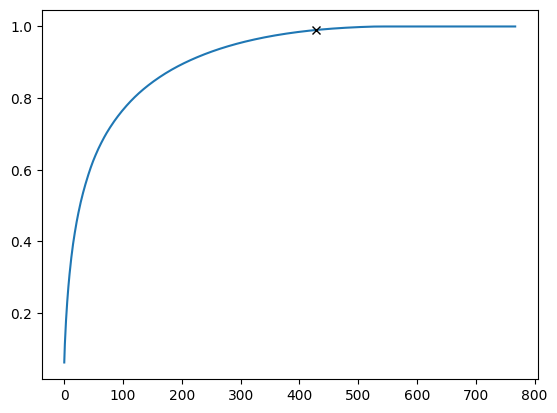

In [11]:
# do PCA
import sklearn.decomposition as D
import pickle

# transform data
pca = D.PCA().fit(product_10k_features)
var_sum = np.cumsum(pca.explained_variance_ratio_)
idx = np.where(var_sum > 0.99)[0][0]

pca_path = 'my_experiments/ViT-L-14-laion2b_s32b_b82k-image_net-v2-product-10k-ArcFace(k=3)-All/pca_epoch_4.pkl'
pca_ = D.PCA(idx).fit(product_10k_features)
with open(pca_path, 'wb') as f:
    pickle.dump(pca_, f)

plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), '-')
plt.plot(idx, var_sum[idx], 'xk')

In [12]:
features_test = pca_.transform(features_test)
features_train = pca_.transform(features_train)

In [6]:
dist, ind = utilities.get_similiarity_l2(features_train, features_test, 10000)

Processing indices...
Finished processing indices, took 0.316131591796875s


In [7]:
def calculate_map_scores(product_id_test, product_id_train, ind):
    map_score_per_image = []

    for i, product_id in enumerate(tqdm(product_id_test)): 
        loc_ = np.where(product_id_train[ind[i]] == product_id_test[i])[0] + 1
        map_score_per_image.append(np.sum(np.arange(1, len(loc_[:3]) + 1) / loc_[:3]) / 3)

    map_score_per_image = np.array(map_score_per_image)
    print(f"Mean AP@3 is {np.mean(map_score_per_image)}")
    worst_to_best = np.argsort(map_score_per_image)
    return worst_to_best, map_score_per_image


In [8]:
worst_to_best, map_score_per_image = calculate_map_scores(product_id_test, product_id_train, ind)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1935/1935 [00:00<00:00, 57661.96it/s]

Mean AP@3 is 0.32876324537464247


In [9]:
def plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_q, 
             product_id_g, 
             distances,
             map_score
            ):
    imgs = [read_img(os.path.join(img_dir, img_path_q))]
    imgs.extend([read_img(os.path.join(img_dir, img_path)) for img_path in img_path_g])
    
    fig = plt.figure(figsize=(26, 4))
    for i in range(len(imgs)):
        img = imgs[i]
        fig.add_subplot(1, len(imgs) + 1, i+1)
        if i == 0:
            title = f'Product ({product_id_q})\nP@3({map_score:.2f})'
        else:
            title = f'''Product ({product_id_g[i-1]})\nDist({distances[i-1]:.2f})'''
        plt.title(title, fontsize=10)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

1343 predictions [5279 5349 5291 5296 5319 5279 5111 5296 5144 5078 5070 5196 5159 5340
 5103] truth 5347


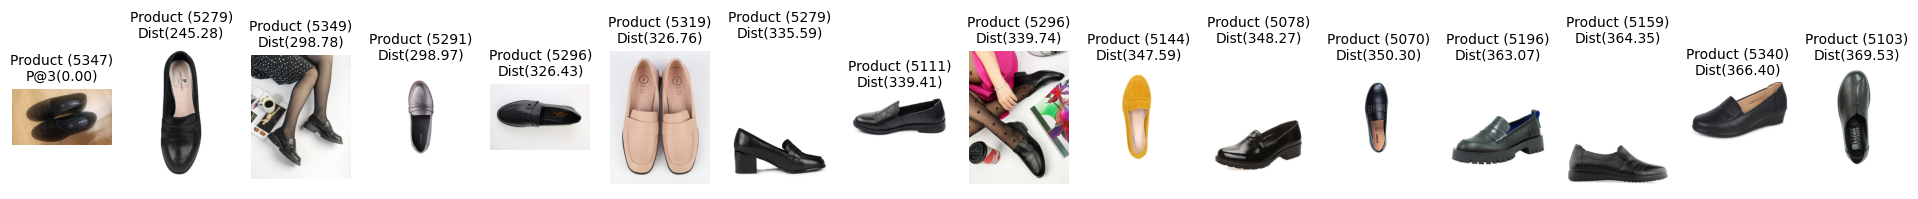

1300 predictions [5087 5330 5197 5197 5197 4978 5162 5141 5336 5316 5246 5106 5316 5336
 5316] truth 5198


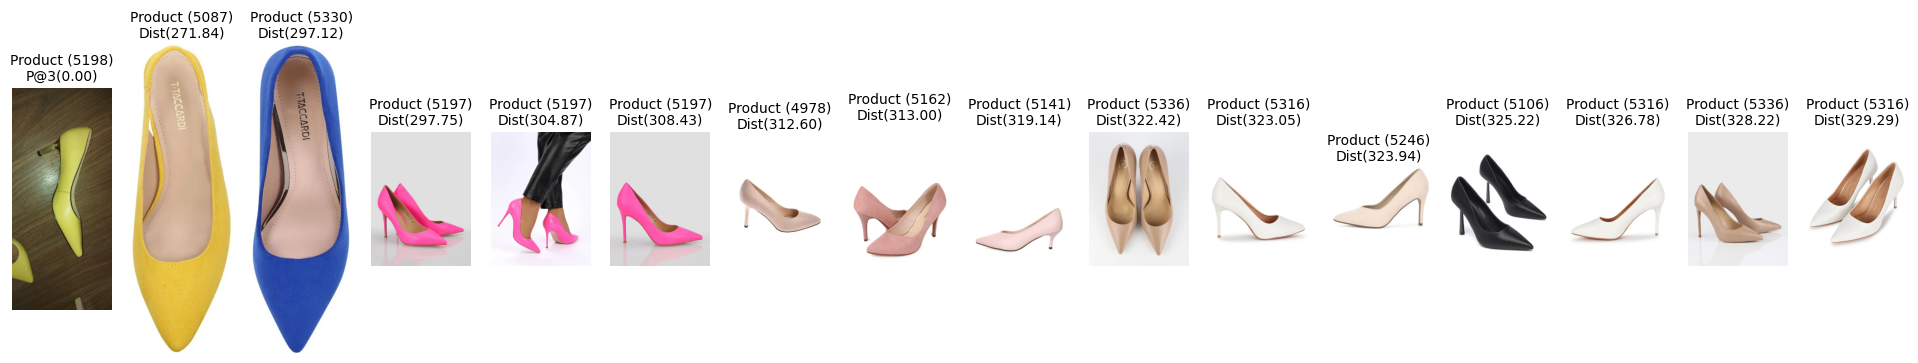

152 predictions [3556 3546 3633 3539 3620 3556 3516 3475 3497 3610 3704 3480 3534 3545
 3466] truth 3611


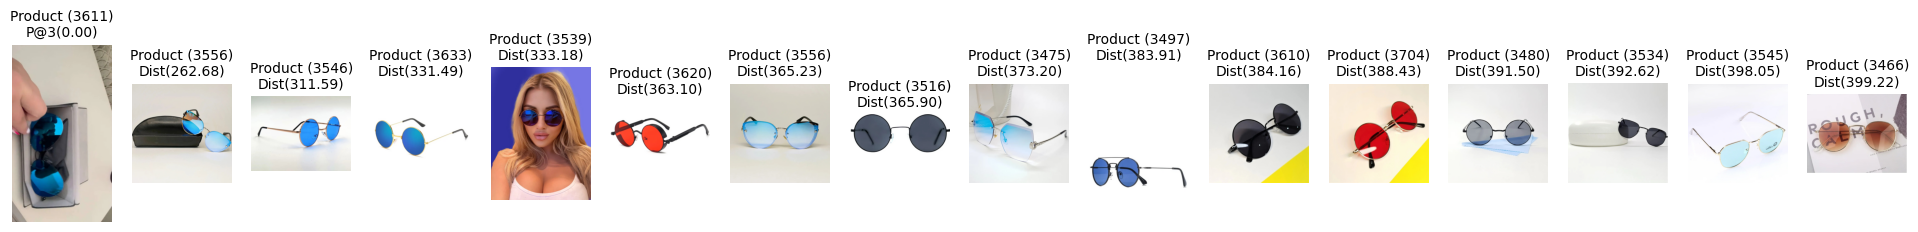

1626 predictions [3648 3488 3692 3692 3692 3574 3578 3578 3574 3595 3692 3461 3570 3670
 3595] truth 3492


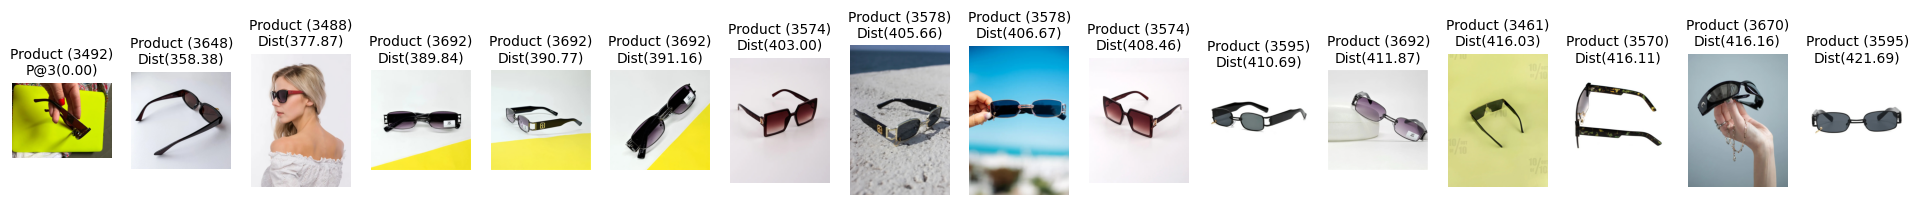

782 predictions [3594 3594 3594 3545 3568 3528 3696 3564 3545 3696 3486 3528 3598 3486
 3696] truth 3504


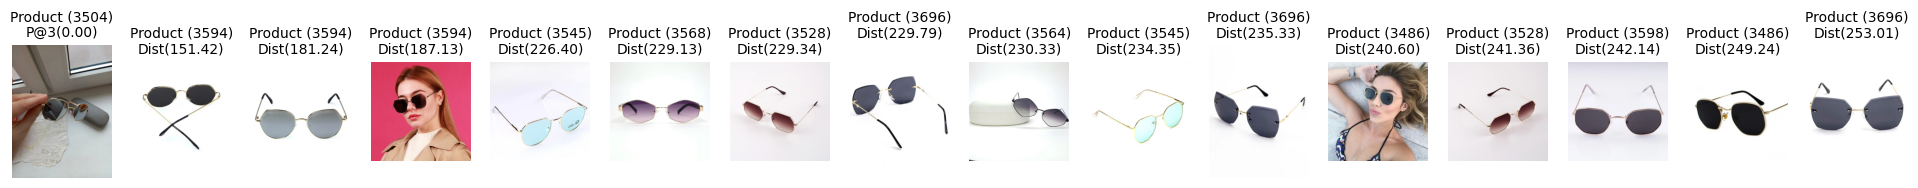

532 predictions [3594 3696 3594 3568 3696 3475 3528 3594 3598 3696 3528 3486 3545 3564
 3664] truth 3504


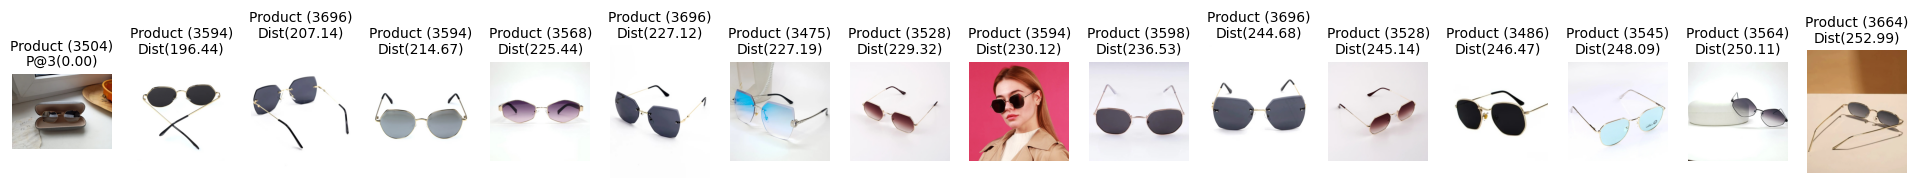

904 predictions [3555 3527 3555 3555 3470 3462 3659 3527 3659 3572 3572 3571 3470 3494
 3499] truth 3596


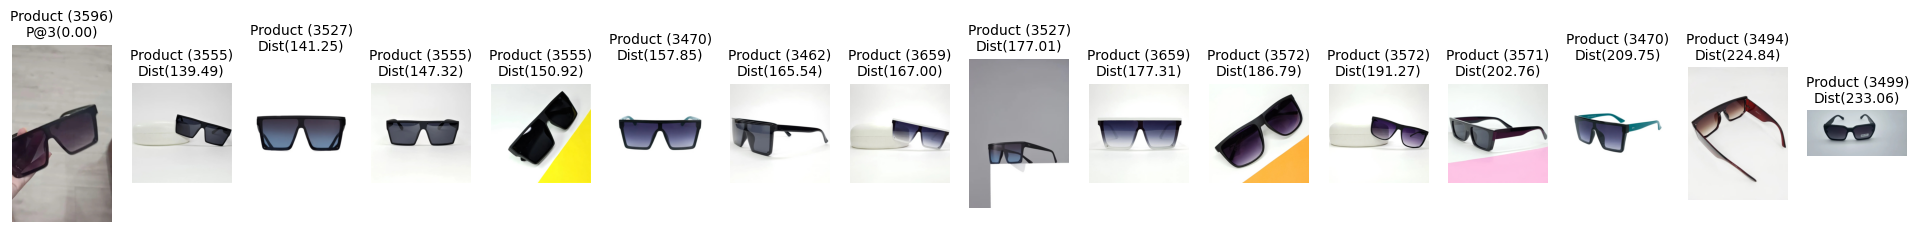

667 predictions [5232 5046 5232 5284 4960 5284 5203 5157 5039 5030 5046 5343 5352 5095
 5191] truth 4994


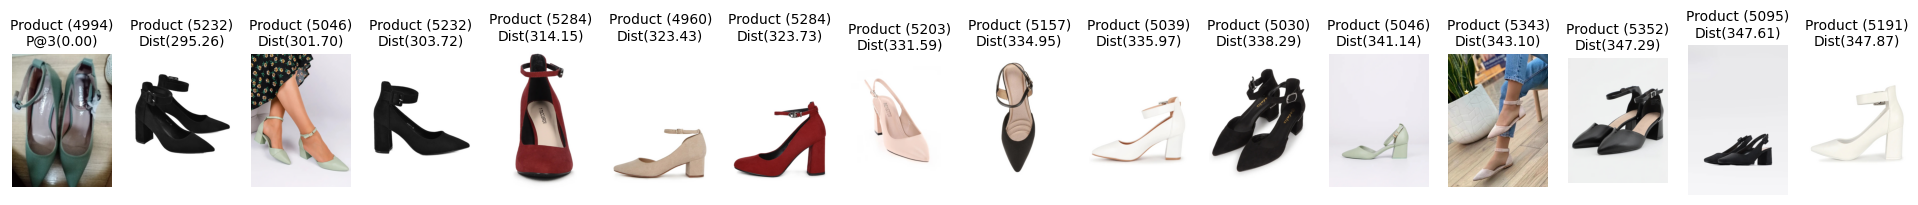

844 predictions [5053 5337 5316 5351 5141 5109 4955 5254 5110 5247 5295 4981 5207 5295
 5074] truth 5235


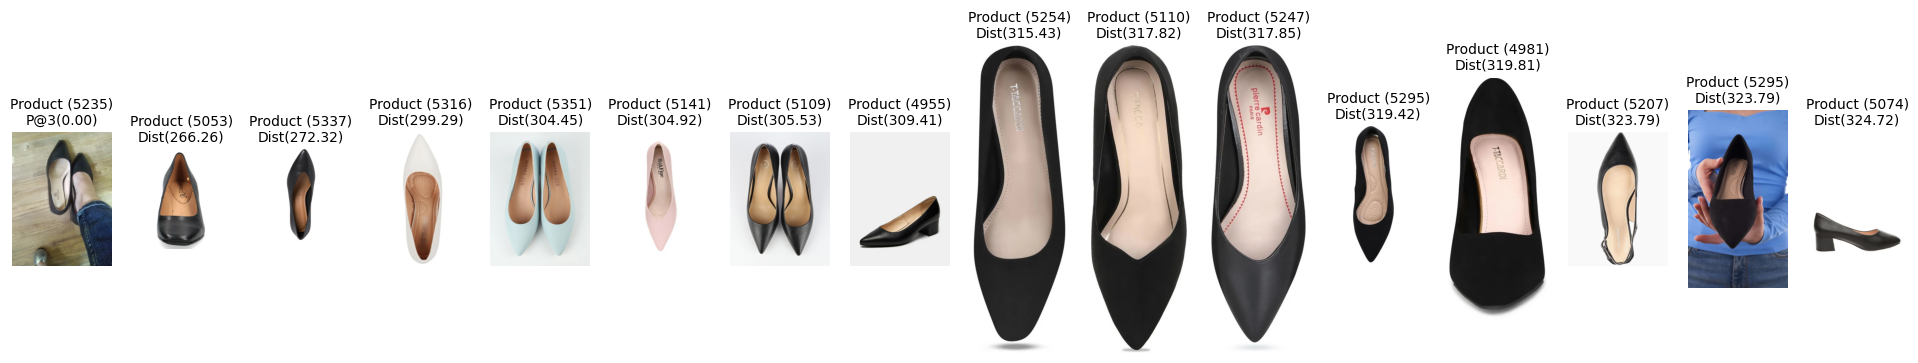

1752 predictions [5349 5279 5196 5296 5196 5073 5078 5279 5296 5196 5078 5297 5073 5223
 5297] truth 5347


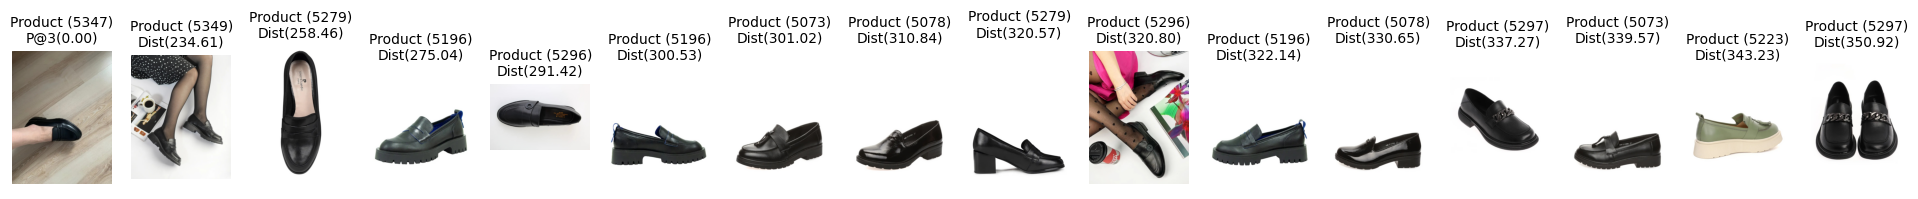

1326 predictions [5349 5279 5196 5073 5078 5296 5196 5073 5196 5073 5279 5078 5297 5223
 5319] truth 5347


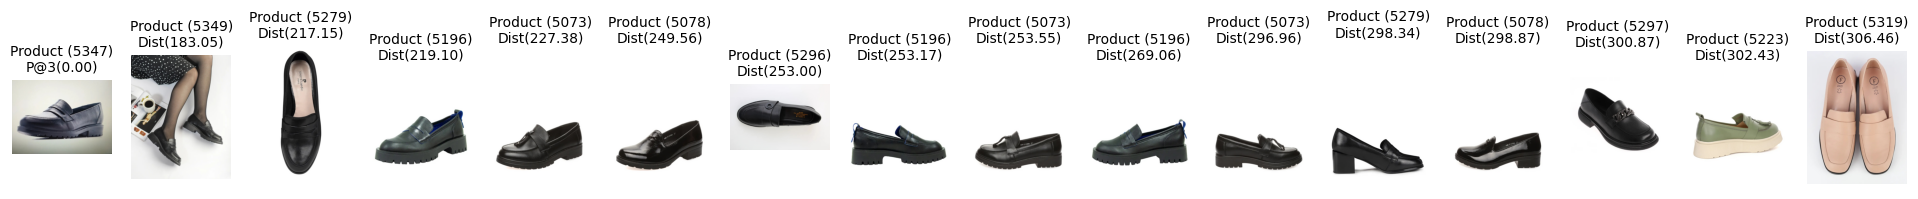

918 predictions [5303 5303 5110 5295 5254 5303 5154 5246 4981 5154 5006 4985 5330 5205
 5255] truth 5264


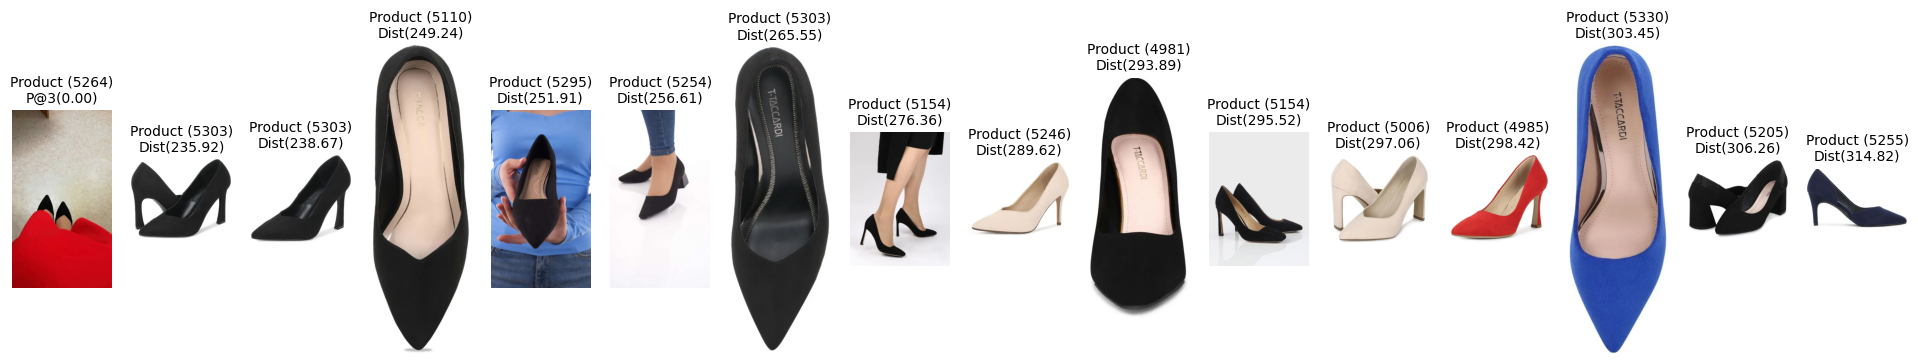

147 predictions [4971 5250 5250 5250 5205 5242 5134 5303 4981 5303 5230 5242 5030 5303
 5254] truth 5145


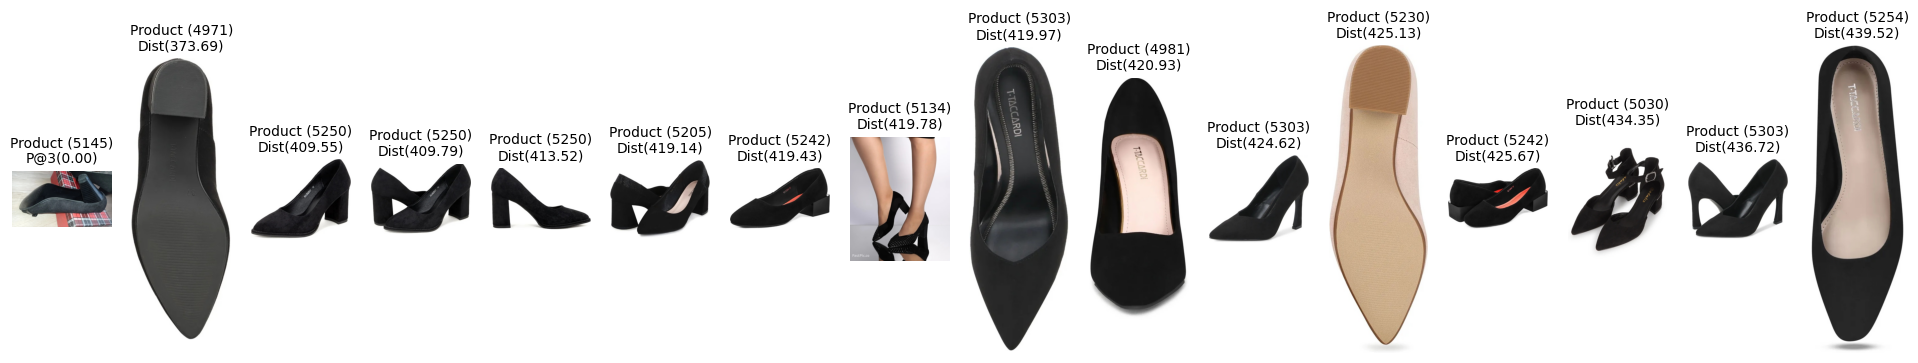

547 predictions [5038    5 3495 3610 3670 5017 3480 5303 3559 5303 3507 3683 5059 3616
 5134] truth 5267


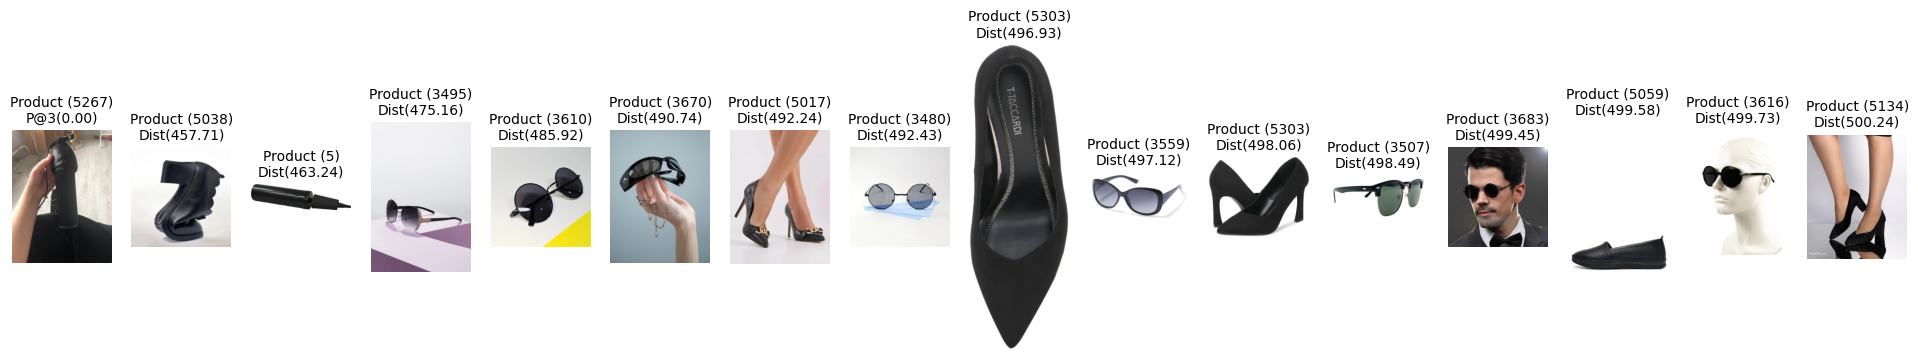

445 predictions [3564 3645 3645 3594 3564 3672 3696 3594 3696 3696 3594 3528 3528 3486
 3675] truth 3638


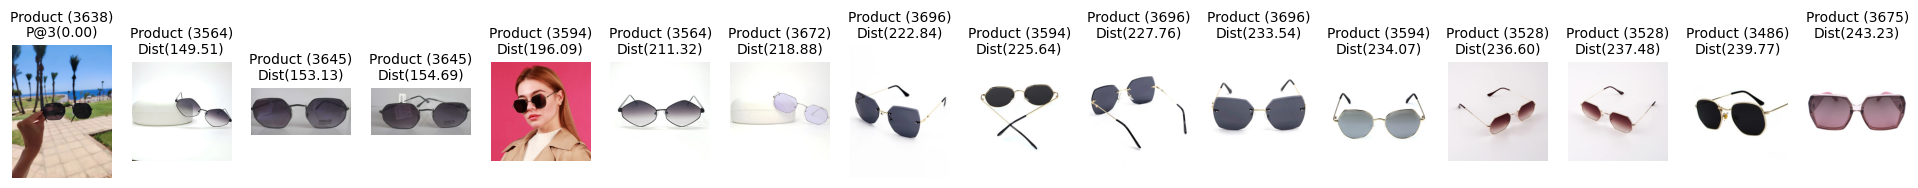

1444 predictions [3468 3503 3562 3562 3634 3531 3687 3514 3468 3549 3536 3702 3674 3488
 3674] truth 3677


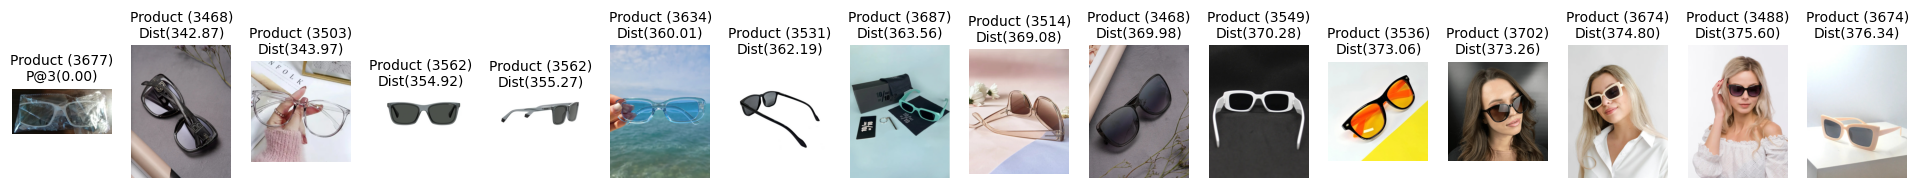

672 predictions [3520 3498 3553 3615 3590 3670 3468 3468 3607 3624 3531 3669 3627 3627
 3509] truth 3621


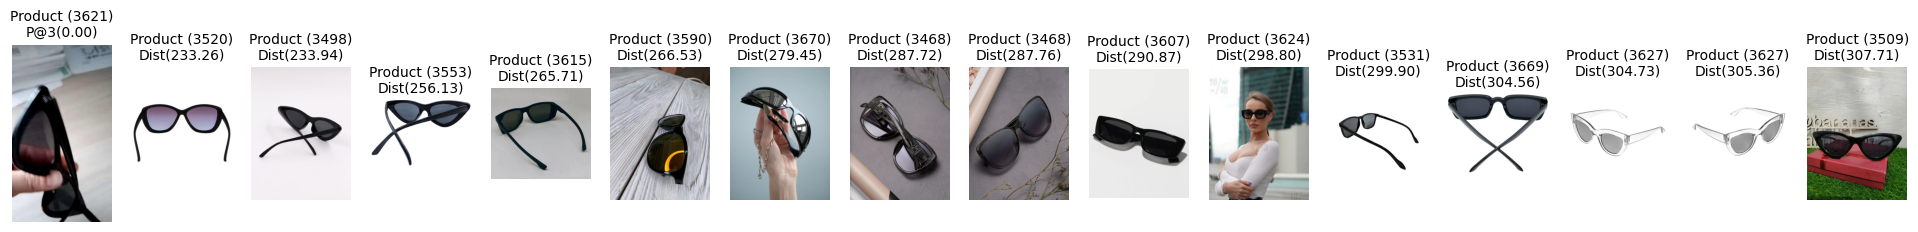

261 predictions [3468 3520 3622 3488 3572 3590 3702 3702 3648 3468 3590 3615 3684 3615
 3498] truth 3459


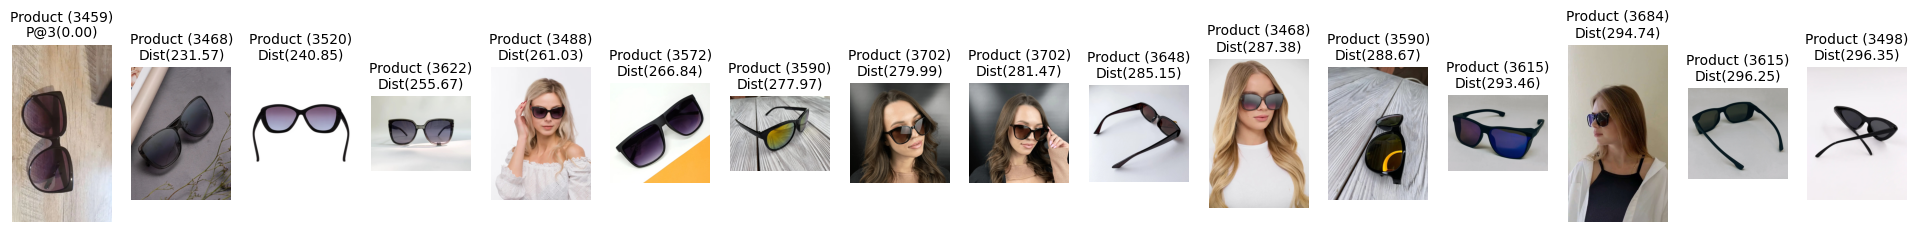

1035 predictions [3594 3664 3528 3696 3486 3594 3594 3598 3696 3486 3475 3545 3528 3696
 3564] truth 3504


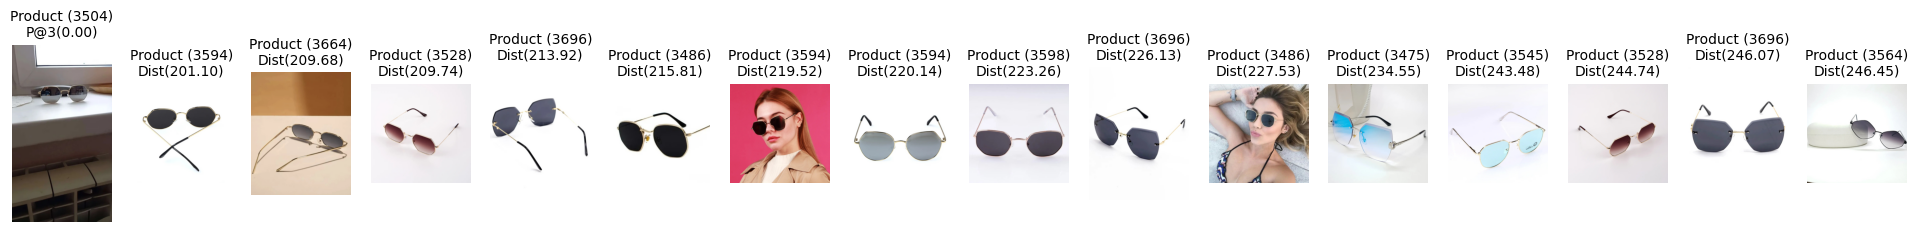

211 predictions [3673 3687 3514 3490 3687 3673 3673 3541 3472 3702 3472 3702 3584 3551
 3587] truth 3491


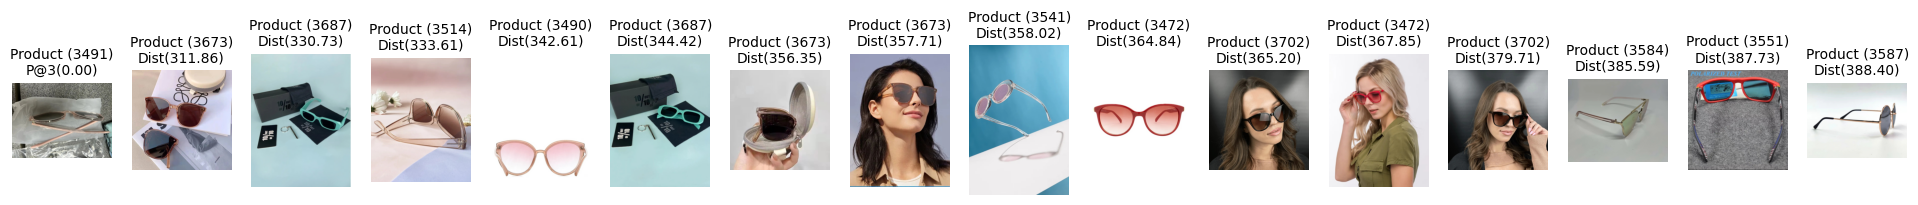

In [13]:
for i in worst_to_best[20:40]:
    idx_ = ind[i][:15]
    
    print(i, 'predictions', product_id_train[idx_], 'truth', product_id_test[i])
    img_path_q = img_path_test[i]
    img_path_g = [img_path_train[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_test[i], 
             product_id_train[idx_], 
             dist[i],
             map_score_per_image[i])

187 predictions [5144 5144 5144 5253 4967 5087 5087 5274 5140 5274 5185 5330 5185 5339
 5063] truth 5144


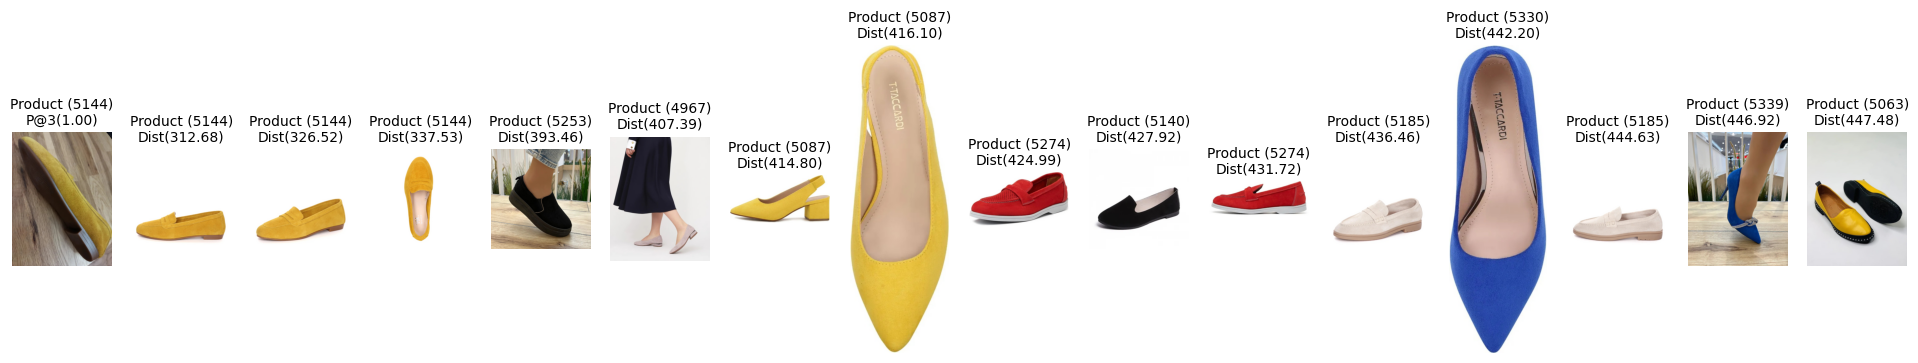

4 predictions [5329 5329 5329 5129 5052 5129 5052 5047 5165 4997 5135 5224 5209 5059
 5059] truth 5329


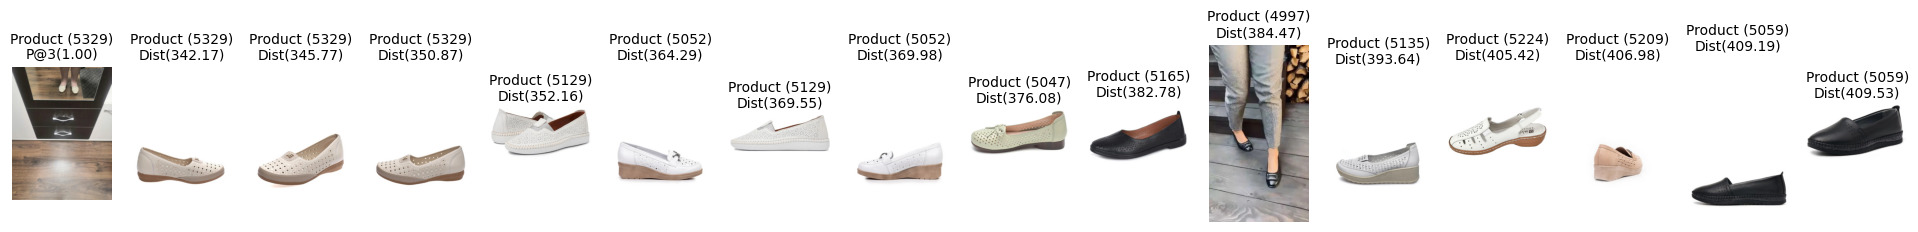

1282 predictions [5225 5225 5225 5261 5261 5303 5213 5168 5205 5250 5290 5303 5213 5250
 4952] truth 5225


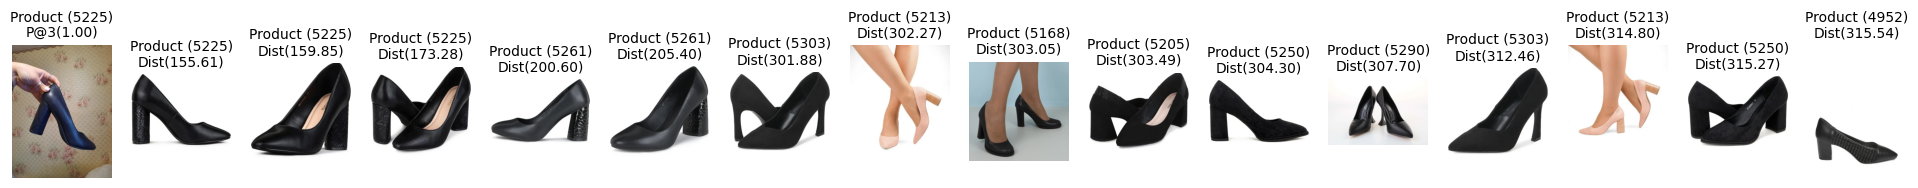

216 predictions [5014 5014 5014 5314 5324 4975 4949 5191 5343 5202 4949 4949 5339 5308
 5302] truth 5014


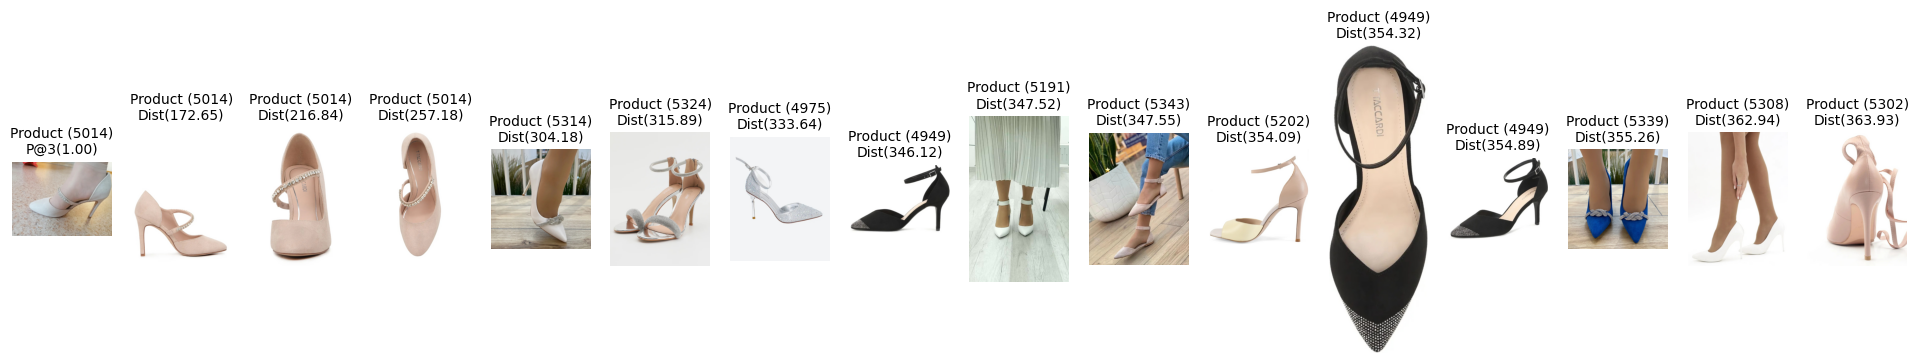

1434 predictions [5176 5176 5176 5186 5096 5201 5160 4990 5059 5129 5129 5059 5096 5258
 5253] truth 5176


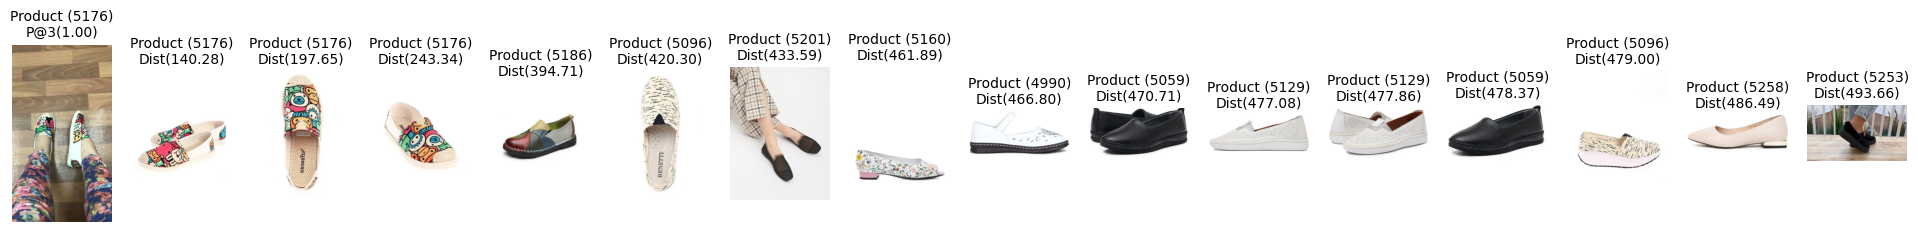

1302 predictions [5179 5179 5179 5179 5011 5262 5180 5047 5224 5224 5055 5129 5278 5271
 5052] truth 5179


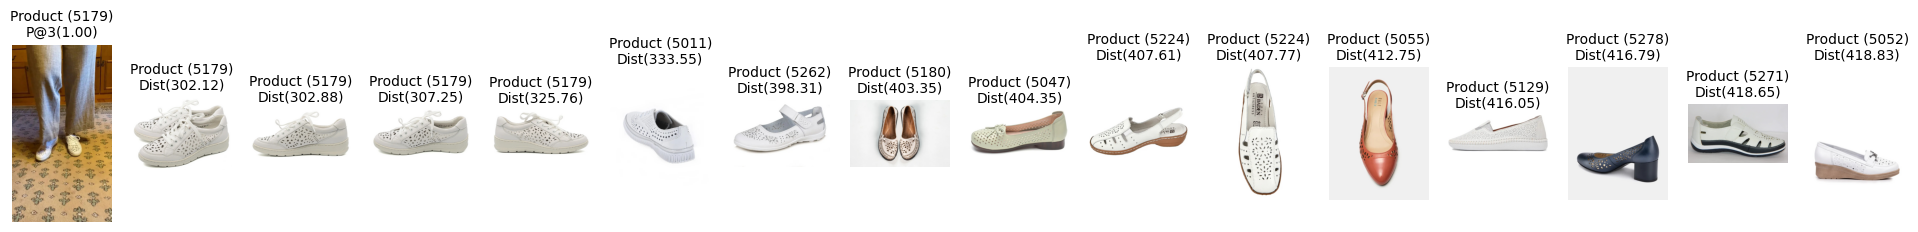

183 predictions [3681 3681 3681 3699 3669 3574 3631 3578 3574 3524 3485 3639 3696 3703
 3703] truth 3681


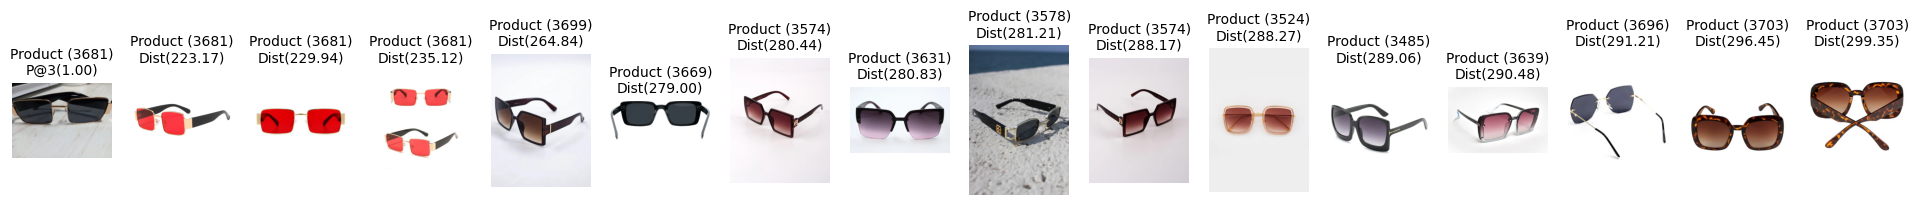

1528 predictions [5008 5008 5008 5008 5008 5178 5291 5196 5178 5196 5223 5073 5196 4989
 5297] truth 5008


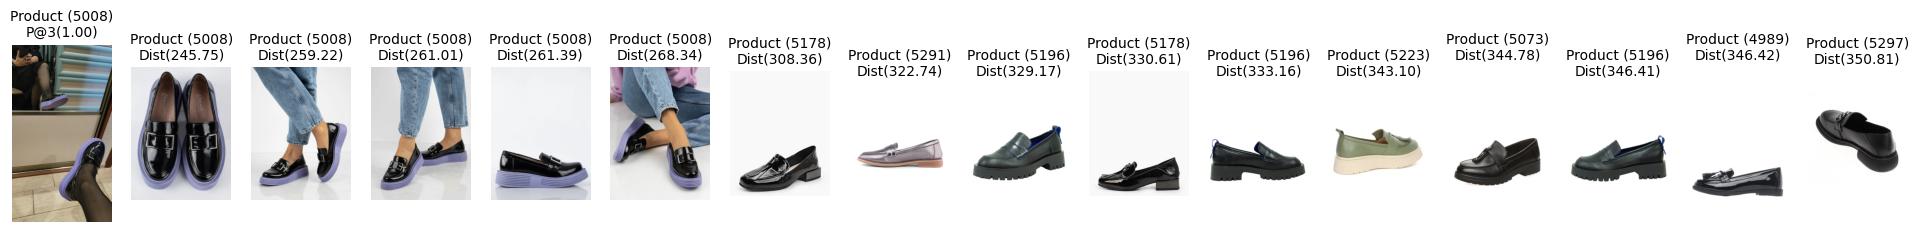

1918 predictions [5210 5210 5210 5009 5009 5227 5042 5213 5082 5201 5177 5047 5099 4951
 5082] truth 5210


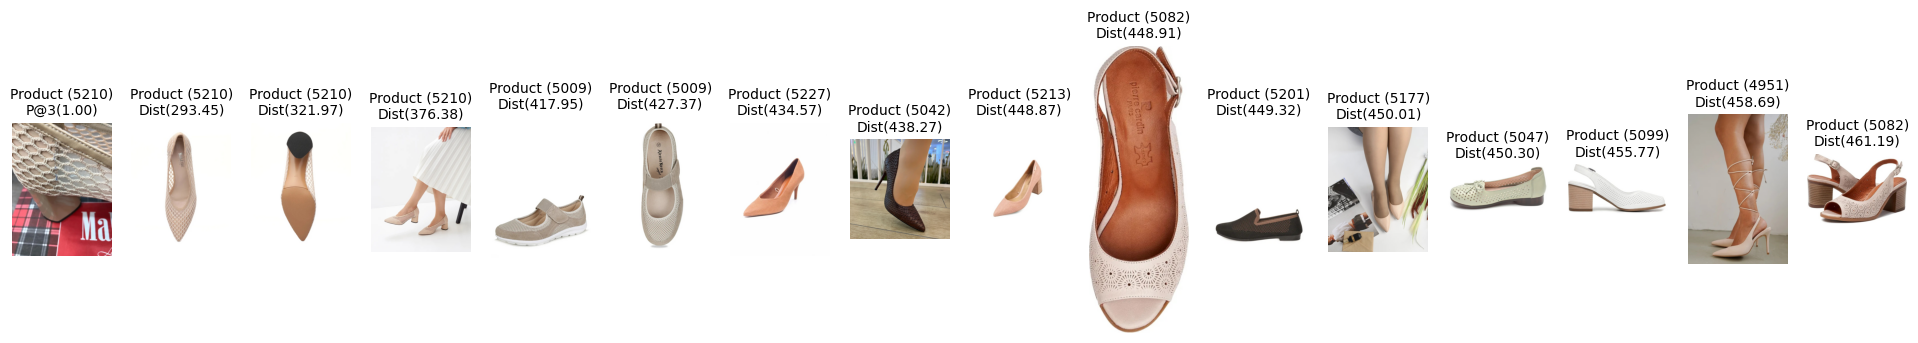

1533 predictions [5073 5073 5073 5108 5073 5349 5131 5268 5196 5297 5130 5297 5078 5297
 5335] truth 5073


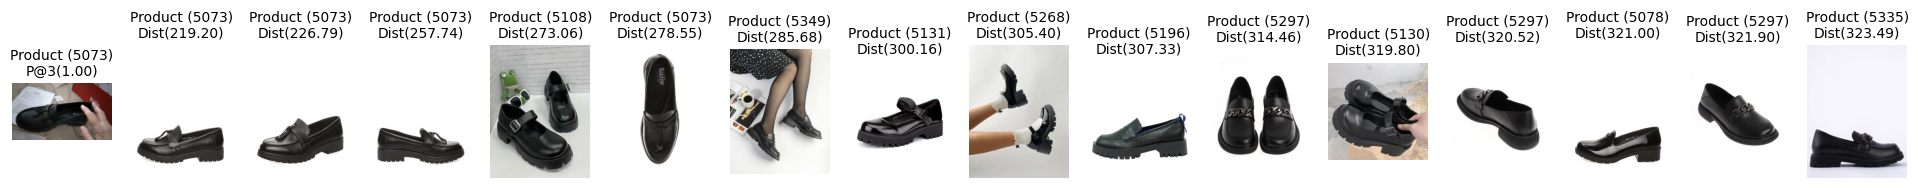

In [11]:
for i in worst_to_best[-100:-90]:
    idx_ = ind[i][:15]
    
    print(i, 'predictions', product_id_train[idx_], 'truth', product_id_test[i])
    img_path_q = img_path_test[i]
    img_path_g = [img_path_train[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_test[i], 
             product_id_train[idx_], 
             dist[i],
             map_score_per_image[i])

## Shopee

In [19]:
img_dir = "../shopee/train_images"

In [20]:
final_transform = get_final_transform()

dataset_shopee = ProductDataset(img_dir, 
                              '../shopee/train.csv', 
                              None, 
                              final_transform, 
                              headers = {"img_path": "image", "product_id": "label_group"})
dataloader_shopee = DataLoader(dataset_shopee, batch_size=512, num_workers=4)

features_shopee, img_path_shopee, product_id_shopee = extract_embeddings(model, dataloader_shopee, 1)



 58%|█████████████████████████████████████████████████████████████                                            | 39/67 [01:14<00:51,  1.83s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1c1b5aff70>
Traceback (most recent call last):
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/mult

KeyboardInterrupt: 

In [ ]:
unique = np.unique(product_id_shopee)
for i in tqdm(range(len(product_id_shopee))):
    product_id_shopee[i] = np.where(unique == product_id_shopee[i])[0][0]

In [ ]:
dist_shopee, ind_shopee = utilities.get_similiarity_l2(features_shopee, features_shopee, 16)
worst_to_best_shopee, map_score_per_image_shopee = calculate_map_scores(
    product_id_shopee, 
    product_id_shopee, 
    ind_shopee
)

In [ ]:
for i in worst_to_best_shopee[10:20]:
    idx_ = ind_shopee[i][1:]
    
    print(i, 'predictions', product_id_shopee[idx_], 'truth', product_id_shopee[i])
    img_path_q = img_path_shopee[i]
    img_path_g = [img_path_shopee[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_shopee[i], 
             product_id_shopee[idx_], 
             dist_shopee[i][1:],
             map_score_per_image_shopee[i])

In [ ]:
for i in worst_to_best_shopee[-120:-110]:
    idx_ = ind_shopee[i][1:]
    
    print(i, 'predictions', product_id_shopee[idx_], 'truth', product_id_shopee[i])
    img_path_q = img_path_shopee[i]
    img_path_g = [img_path_shopee[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_shopee[i], 
             product_id_shopee[idx_], 
             dist_shopee[i][1:],
             map_score_per_image_shopee[i])

In [44]:
%%timeit -n 5

emb1 = np.random.random((9000, 512)).astype(np.float32)
emb2 = np.random.random((1100, 512)).astype(np.float32)
index = faiss.IndexFlatL2(512)
index.add(emb1)
_, ind = index.search(emb2, 1000)

313 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [ ]:
310 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
